In [1]:
import numpy as np
import pandas as pd

# Happiness inside a job: a social network analysis

## Index

1. [Structure of the database](#1.-Structure-of-the-database)

# 1. Structure of the database

## 1.1 What is Happyforce

During these examples we will be dealing with a database provided by **[Happyforce](http://www.myhappyforce.com/es/#four-steps)**.  It contains anonimized information about the votes, comments and interactions among the different users of the application. #TODO: detailed introduction.

TODO: expain how the app work +images

## 1.2 Happyness votes data

The data regarding the votes of the app users is stored in **votes.csv**. This file containg 4 different columns:

- **employee**: An integer id that identifies an amployee inside a company.
- **companyAlias**: A hash id for a given company that uses the app. An employee can be uniquely identified with the tuple (employee,companyAlias).
- **voteDate**: String representing the date a given vote was emited.
- **vote**: The numeric value of the vote emited ranging from 1 to 4.

In [2]:
votes = pd.read_csv('data/votes.csv',parse_dates=[2]).drop_duplicates()
votes.head(3)

,employee,companyAlias,voteDate,vote
0,31,56aec740f1ef260003e307d6,2016-02-01,4
1,33,56aec740f1ef260003e307d6,2016-02-01,4
2,79,56aec740f1ef260003e307d6,2016-02-01,4


## 1.3 Comments data

It is possible to find data about the comments written in the app in the **anon_comments.csv** file, and it has the following structure:

- **employee**: An integer id that identifies an amployee inside a company.
- **companyAlias**: A hash id for a given company that uses the app. An employee can be uniquely identified with the tuple (employee,companyAlias).
- **commentDate**: String representing the date a given comment was written.
- **commentId**: A unique id for a given comment.
- **comment**: Anonimized comment. It has the same length as the original comment. 
- **likes**: Number of likes that the comment received.
- **dislikes**: Number of dislikes that the comment received.

In [3]:
comments = comments = pd.read_csv('data/anon_comments.csv',parse_dates=[-1]).drop('Unnamed: 0',axis=1)
comments.head(3)

,employee,companyAlias,commentId,comment,likes,dislikes,commentDate
0,307,56aec740f1ef260003e307d6,58d018d7e010990004e38070,**********************************************...,4.0,0.0,2017-03-20 18:00:17
1,382,56aec740f1ef260003e307d6,58d0179ae010990004e3806d,*****************************,1.0,2.0,2017-03-20 17:55:16
2,172,56aec740f1ef260003e307d6,58cff8cde010990004e37f6a,***************************,3.0,0.0,2017-03-20 15:44:02


## 1.3 Employee Interactions

The file **commentInteractions.csv** contains information about which employee liked or disliked a given comment.

- **employee**: An integer id that identifies an amployee inside a company.
- **companyAlias**: A hash id for a given company that uses the app. An employee can be uniquely identified with the tuple (employee,companyAlias).
- **commentId**: A unique id for a given comment that allows us to relate it with the comments in anon_comments.csv.

- **liked**: A boolean that is True if the employee liked the comment.
- **disliked**: A boolean that is True if the employee disliked the comment.

In [4]:
inters = pd.read_csv('data/commentInteractions.csv').dropna(how='any').drop_duplicates()
inters.head(3)

/home/kalidus/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,employee,companyAlias,liked,disliked,commentId
0,307,56aec740f1ef260003e307d6,True,False,58d018d7e010990004e38070
1,36,56aec740f1ef260003e307d6,True,False,58d018d7e010990004e38070
2,276,56aec740f1ef260003e307d6,True,False,58d018d7e010990004e38070


## 1.4 Last participation date of employees

The **lastParticipationExists.csv** file contains information about the date of the last interaction of an employee with the app.

- **employee**: An integer id that identifies an amployee inside a company.
- **companyAlias**: A hash id for a given company that uses the app. An employee can be uniquely identified with the tuple (employee,companyAlias).
- **numVotes**: Total number of happyness votes emited by the user.
- **lastParticipationDate**: Date of the last interaction of the user with the app.
- **stillExists**: Boolean that is True if the user is still registered in the app.

In [5]:
lastpart = pd.read_csv('data/lastParticipationExists.csv',parse_dates=[3]).drop_duplicates()
lastpart.head(3)

,employee,companyAlias,numVotes,lastParticipationDate,stillExists
0,512,56aec740f1ef260003e307d6,4,2017-02-23 11:48:04,True
1,-2,56aec740f1ef260003e307d6,0,2017-01-18 13:00:55,False
2,2,56aec740f1ef260003e307d6,72,2017-03-17 00:00:00,True


# 2. Data cleaning process

We would like to use this data to predict the future happyness of an employee base on its past interactions with the app. In order to get a suitable dataset for this task we will follow the following process:

1. **Select an arbitrary prediction date.** <p>
    Only data prior to 26 Dec 2016 will be used to build our training and evaluation datasets.<p>
2. **Use only data belonging non churned employees**.<p>
    All the employees that churned before the prediction date will be removed from the training and test set. <p>
3. **Use only data belonging to active employees**.<p>
    We will only take into account employees that voted at least 5 times before the predictions date and 2 times after the prediction date and before the data collection period ended.  <p>
5. **Employees with more than 5 likes/dislikes**.<p>
    We will only take into account employees that liked or disliked a comment at least 5 times during the observation period.  <p>
    
5. **Creating a target variable**.<p>
    The target variable for this use case will be a binary variable that relates to the happyness level of an employee. If the mean of the votes emited by an employee is greater than 2, the target variable will be 1, otherwise it will be 0.  <p>

## 2.1 Filtering by an arbitrary prediction date

In order to filter the data set by dates and remove the unwanted employees we need calculate the first date an employee interacted with the app. 

In [6]:
#get first dates on different DataFrames
min_date_comment = pd.DataFrame(comments.groupby(['companyAlias','employee'])['commentDate'].apply(np.min))
min_date_votes = pd.DataFrame(votes.groupby(['companyAlias','employee'])['voteDate'].apply(np.min))
min_date_part = pd.DataFrame(lastpart.groupby(['companyAlias','employee'])['lastParticipationDate'].min())
#combine them
min_dates = pd.merge(min_date_comment,min_date_votes,right_index=True,left_index=True,how='outer')
min_dates = pd.merge(min_dates,min_date_part,right_index=True,left_index=True,how='outer')
#take the earliest date of the 3 different DataFrames and propagate nans employee wise
first_dates = pd.DataFrame(min_dates.fillna(method='ffill',axis=1).fillna(method='bfill',axis=1).min(axis=1),
                           columns=['first_date'])
first_dates.head(3)

first_date
companyAlias             employee                    
5370af43e4b0cff95558c12a -117     2016-03-04 09:55:34
                         -116     2016-09-12 11:53:45
                         -115     2016-09-12 11:54:00

Now we create a DataFrame containing the first date of app usage, the last date an employee used the app, and  a column that indicates if the user is still registered in the app. Now we can filter employees by periods of activity.

In [7]:
last_dates = lastpart.set_index(['companyAlias','employee'])[['lastParticipationDate','stillExists']].copy()
dates = pd.merge(first_dates,last_dates,right_index=True,left_index=True,how='outer')
dates.ix[-5:-1].head()

first_date lastParticipationDate stillExists
companyAlias             employee                                             
58c6e15f32f72a00046f556c 58       2017-03-14   2017-03-14 23:13:43        True
                         59       2017-03-14   2017-03-14 23:13:43        True
                         60       2017-03-14   2017-03-20 14:29:20        True
                         61       2017-03-14   2017-03-14 23:13:43        True

## 2.2 Filtrering employees

- We delete employees churned before 16 Feb 2017 (data collection ended).
- We delete employees that started using the app after 1 feb 2017(prediction date).



In [8]:
prediction_date = '6 Feb 2017'
data_collection_ended = '19 Feb 2017'

In [9]:
c_first = dates['first_date']<=pd.to_datetime(prediction_date)
c_last = dates['lastParticipationDate']>pd.to_datetime(data_collection_ended)
users_index = dates[c_first&c_last].copy()

In [10]:
len(users_index.reset_index()['companyAlias'].unique()),len(users_index.index)

(21, 1694)

This means that we will be dealing with 1710 employees across 21 different companies. You can see in the following plot the number of employees of every company. 

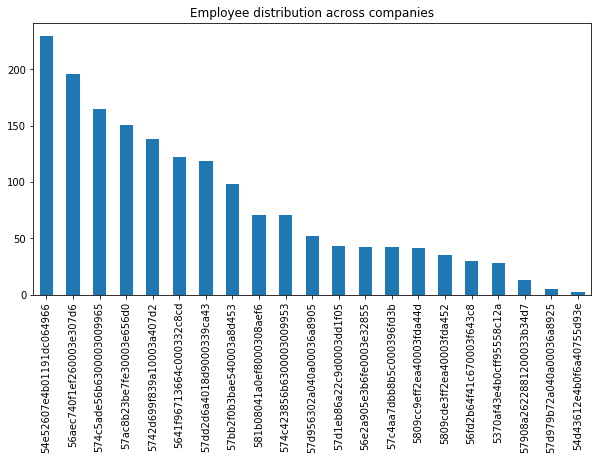

In [11]:
%matplotlib inline
users_index.reset_index()['companyAlias'].value_counts().plot(kind='bar',
                                                              figsize=(10,5),
                                                              title='Employee distribution across companies',
                                                              )

# 2.3 Creating UIDs for every employee

We will create a unique identifier for every employee, so it will be easier to work and filter the data.

In [12]:
#numeric aliases for company istead of a hash
alias_comp = dict([(x,i) for i,x in enumerate(np.unique(users_index.index.levels[0].values).tolist())])
def make_uid(x):
    df = x.reset_index().copy()
    return df['companyAlias'].map(lambda x: str(alias_comp[x])).values+'_'+df['employee'].map(str).values
users_index['uid'] = make_uid(users_index)
inters['uid'] = make_uid(inters)
inters['comid'] = inters['uid'].map(lambda x: x.split('_')[0]).values
votes['uid'] = make_uid(votes)
votes['comid'] = votes['uid'].map(lambda x: x.split('_')[0]).values
comments['uid'] = make_uid(comments)
comments['comid'] = comments['uid'].map(lambda x: x.split('_')[0]).values
lastpart['uid'] = make_uid(lastpart)
lastpart['comid'] = lastpart['uid'].map(lambda x: x.split('_')[0]).values
users_index['uid'] = make_uid(users_index)
users_index['comid'] = users_index['uid'].map(lambda x: x.split('_')[0]).values

inv_comp = dict([(val,key) for key,val in alias_comp.items()])
def inv_company(x):
    c = x.split('_')[0]
    return inv_comp[int(c)]
import pickle 
with open('inverse_alias.pck','wb') as f:
    pickle.dump(inv_comp,f)

This UID has the following form: comid_employee

In [13]:
users_index.head(3)

first_date lastParticipationDate  \
companyAlias             employee                                    
5370af43e4b0cff95558c12a 18       2016-02-22            2017-03-12   
                         25       2016-02-23            2017-03-20   
                         26       2016-03-18            2017-03-06   

                                  stillExists   uid comid  
companyAlias             employee                          
5370af43e4b0cff95558c12a 18              True  0_18     0  
                         25              True  0_25     0  
                         26              True  0_26     0

# 2.4 Remove invalid employees

We will filter out the employees that are not present the in users_index DataFrame.

In [14]:
valid_employees = users_index.uid.unique()
filter_users = lambda x: x['uid'] in valid_employees
#create index of valid employees
coms_ix = comments.apply(filter_users,axis=1)
lastp_ix = lastpart.apply(filter_users,axis=1)
votes_ix = votes.apply(filter_users,axis=1)
ints_ix = inters.apply(filter_users,axis=1)
#users_ix = users_index.apply(filter_users,axis=1)

In [15]:
inters_clean = inters[ints_ix].copy()
votes_clean = votes[votes_ix].copy()
coms_clean = comments[coms_ix].copy()
lastp_clean = lastpart[lastp_ix].copy()

# 2.5 Keep employees that interacted above a threshold

In order to improve the stability of the ML models and improve the improve the overall quality of our data we will only take into account employees that meet the following conditions:

- Voted at least 5 times before the prediction date.
- Voted at least 2 times after the prediction date and before the data collection period ended.
- Liked or disliked a comment at least 5 times before the prediction date.

We will start by creating an index for the different periods that are taken into consideration.

In [17]:
#True before prediction date
target_votes_prev = votes_clean['voteDate']<=pd.to_datetime(prediction_date)
valid_comments = comments[comments.commentDate<=pd.to_datetime(prediction_date)].commentId.unique()
#True before prediction date
target_votes_start = votes_clean['voteDate']>pd.to_datetime(prediction_date)
#True before data collection ended
target_votes_end = votes_clean['voteDate']<=pd.to_datetime(data_collection_ended)

In [18]:
#num votes before prediction date
num_votes_pre = votes_clean[target_votes_prev].groupby(['uid'])['vote'].agg({'votes_num': lambda x: len(x)}).copy().fillna(0)
#num votes after prediction date
num_votes_target = votes_clean[target_votes_start&target_votes_end].groupby(['uid'])['vote'].agg({'votes_num': lambda x: len(x)}).copy().fillna(0)
#total number of likes given
num_likes = inters.groupby('uid')['liked'].sum().astype(int)
num_dislikes = inters.groupby('uid')['disliked'].sum().astype(int)

In [19]:
pre_emp = num_votes_pre[num_votes_pre.values>=5].index.unique().values.tolist()
post_emp = num_votes_target[num_votes_target.values>=2].index.unique().values.tolist()
enough_likes = num_likes[(num_likes.values+num_dislikes.values)>=5].index.unique().values.tolist()
#these are the employee uids that we will be using for machine learning
valid_employees = [e for e in pre_emp if e in post_emp and e in enough_likes]


In [34]:
votes_ml_all = votes_clean[votes_clean['uid'].map(lambda x: x in valid_employees)].copy()
inters_ml = inters_clean[inters_clean['uid'].map(lambda x: x in valid_employees)].copy()
comments_ml = coms_clean[coms_clean['uid'].map(lambda x: x in valid_employees)].copy()
lastpart_ml = lastp_clean[lastp_clean['uid'].map(lambda x: x in valid_employees)].copy()

# 2.6 Creating the training and test datasets

We will create the training set selecting only data belonging to the selected employees over the observation period.

In [35]:
#votes training set
votes_ml = votes_ml_all[votes_ml_all['voteDate']<=pd.to_datetime(prediction_date)]
#comments training set
comments_ml = comments_ml[comments_ml.commentDate<=pd.to_datetime(prediction_date)].copy()
valid_comments = comments_ml.commentId.unique().tolist()
#only interactions belonging to comments posted during the observation period
inters_ml = inters_ml[inters_ml['commentId'].map(lambda x: x in valid_comments)].copy()


# 2.7 Creating the target variable

In [50]:
target_votes_start = votes_ml_all['voteDate']>pd.to_datetime(prediction_date)
#True before data collection ended
target_votes_end = votes_ml_all['voteDate']<=pd.to_datetime(data_collection_ended)

target_happy = votes_ml_all[target_votes_start&target_votes_end].groupby(['uid'])['vote'].agg({'votes_num': lambda x: len(x)}).copy().fillna(0)

target_happy = pd.DataFrame(target_happy.votes_num.map(lambda x: 0 if x<=2 else 1))

# Saving cleaned dataset


In [58]:
votes_ml.to_csv('clean_data/votes_ml.csv')
comments_ml.to_csv('clean_data/comments_ml.csv')
inters_ml.to_csv('clean_data/interactions_ml.csv')
target_happy.to_csv('clean_data/target_ml.csv')